In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import csv
import zipfile
from pathlib import Path

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# The Data


In [ ]:
data = pd.read_csv("Original.csv").set_index('Country')

In [ ]:
data.head()

,Population (2019),# Internet Users (2016),Number of Smartphone users in 2020 (in millions),Number of Smartphone users in 2020,Final Consumption Expenditure (US$),GDP US$ (2019),"Internet Users Watching live games streams worldwide as of 2019, by country (in %)",Total Watch-Time in Hours (YouTube),Basketball (Google Trends),Esports (Google Trends),Twitch (Google Trends),NBA (Google Trends),NBA 2K (Google Trends),Facebook Page Fans,Instagram Followers,Live Views (Twitch),Live Views (YouTube),Total Live Views
Country,,,,,,,,,,,,,,,,,,
Argentina,44938712,31118074,32.37,32370000,421998288518,449663446954,20.0,0.0,13,9,16,2.0,6,0.0,862.0,44527,0,44527
Australia,25364307,21288325,20.30,20300000,1076747538950,1392680589329,13.0,3220.0,19,19,16,19.0,48,879.0,2653.0,64040,13216,77256
Austria,8877067,7346364,7.34,7340000,323796670169,446314739528,9.0,0.0,5,19,18,2.0,6,NaN,NaN,0,0,0
Belgium,11484055,9826872,8.89,8890000,405322483037,529606710418,10.0,0.0,10,17,19,2.0,9,0.0,311.0,0,0,0
Brazil,211049527,126403573,141.45,141450000,1598682000109,1839758040766,24.0,1979.0,6,20,12,2.0,5,793.0,2833.0,194706,19997,214703


In [ ]:
X = data.drop(columns=['Live Views (Twitch)','Live Views (YouTube)','Internet Users Watching live games streams worldwide as of 2019, by country (in %)', 'Number of Smartphone users in 2020 (in millions)', 'Number of Smartphone users in 2020', 'GDP US$ (2019)', 'Final Consumption Expenditure (US$)']).dropna()
X_train = preprocessing.scale(X)

Understanding the correlation between the features:

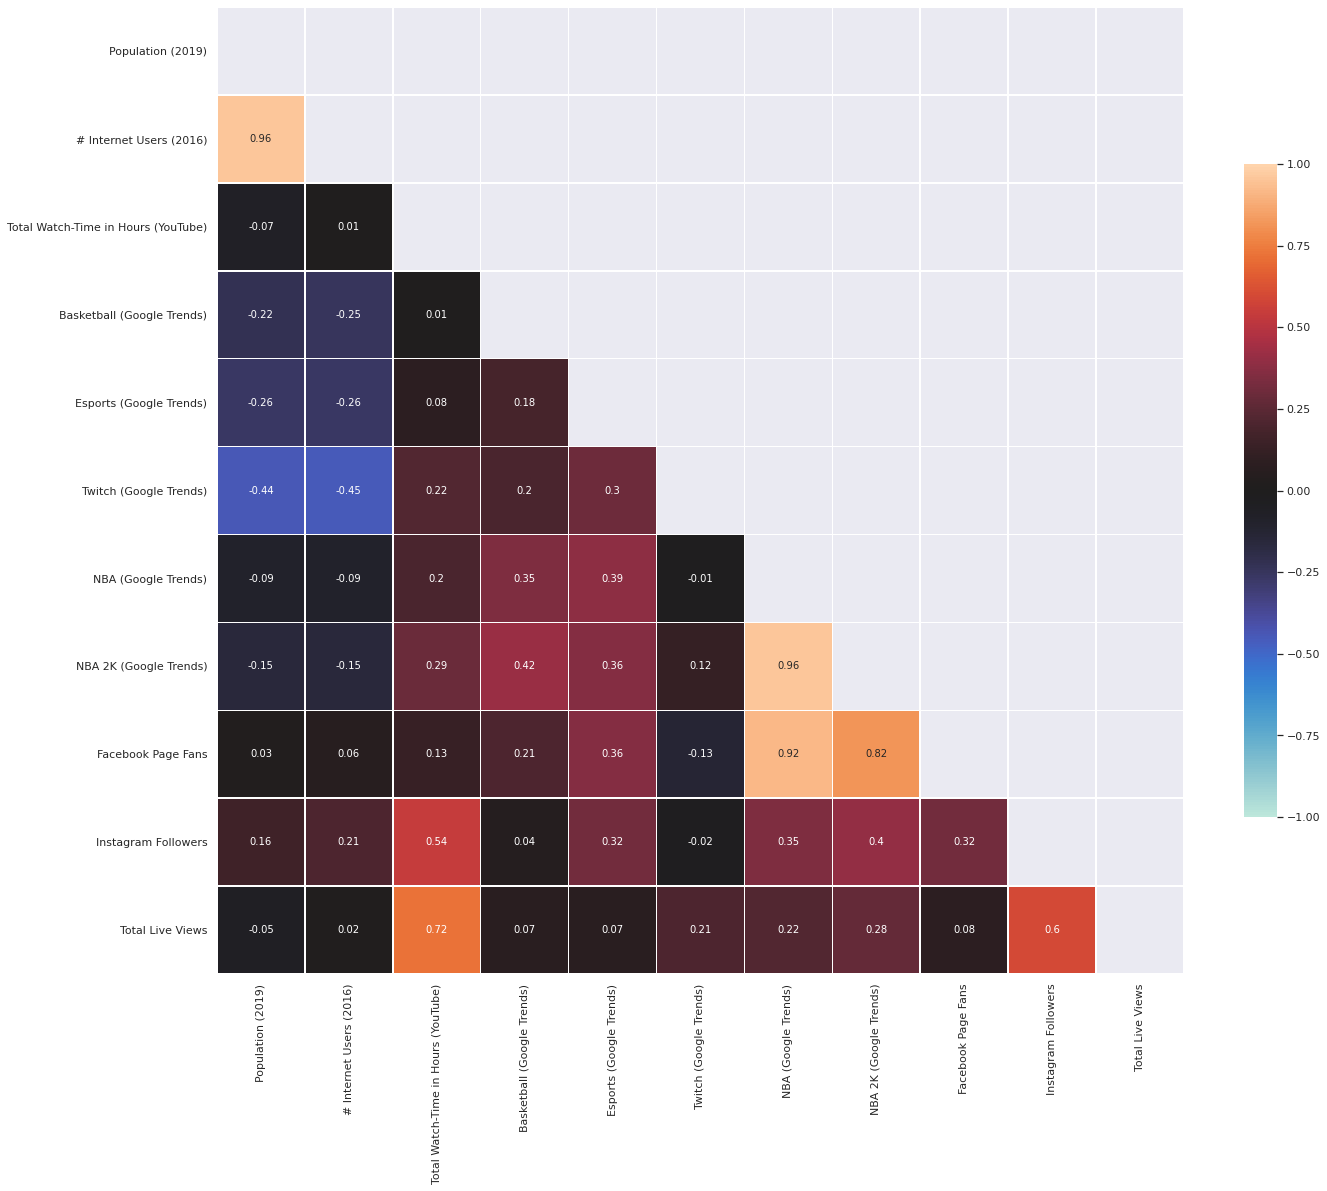

In [ ]:
final_df = pd.DataFrame(X_train)
final_df.columns = X.columns
corr = final_df.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

## Feature Analysis through PCA

Understanding which features influence the PCA components.

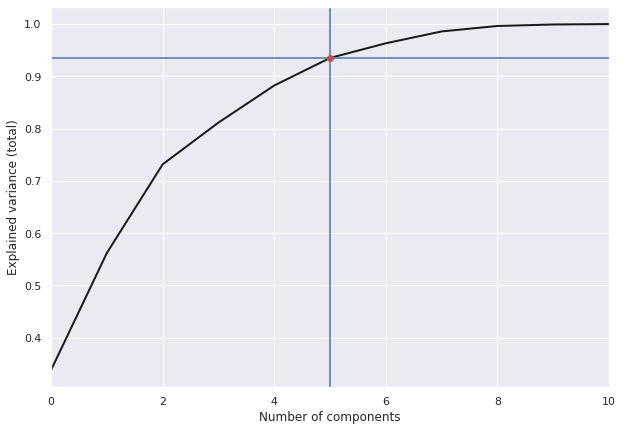

In [ ]:
decomp = PCA().fit(X_train)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(decomp.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Explained variance (total)')
plt.xlim(0, 10)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(5, c='b')
plt.axhline(0.935, c='b')
plt.plot(5, 0.935, 'ro')
plt.show();

Five PCA components make up over 90% of the variance of the data.

**PCA with 5 components**

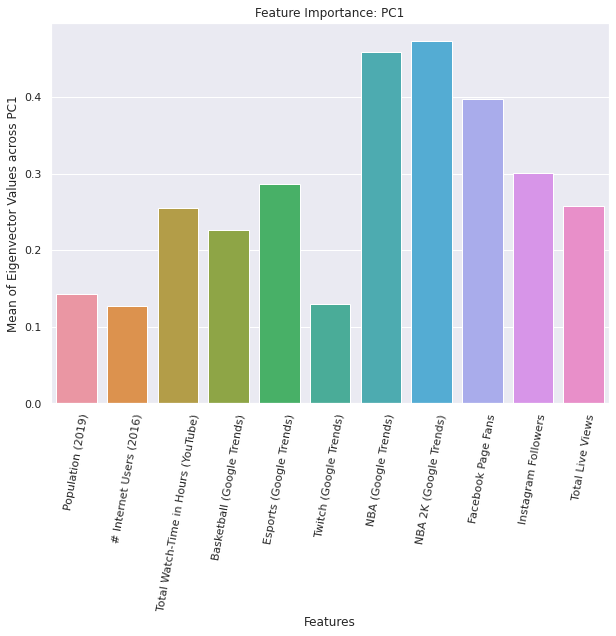

In [ ]:
pca = PCA(n_components=5)
pca_results = pca.fit_transform(X_train) 
feat_imp = pd.DataFrame(pca.components_)
feat_imp.columns = X.columns[:11]
plt.figure(figsize=(10,7))
sns.barplot(x = feat_imp.columns, y = abs(feat_imp.iloc[0,:])).set_title('Feature Importance: PC1')
plt.ylabel('Mean of Eigenvector Values across PC1')
plt.xlabel('Features')
plt.xticks(rotation=80);

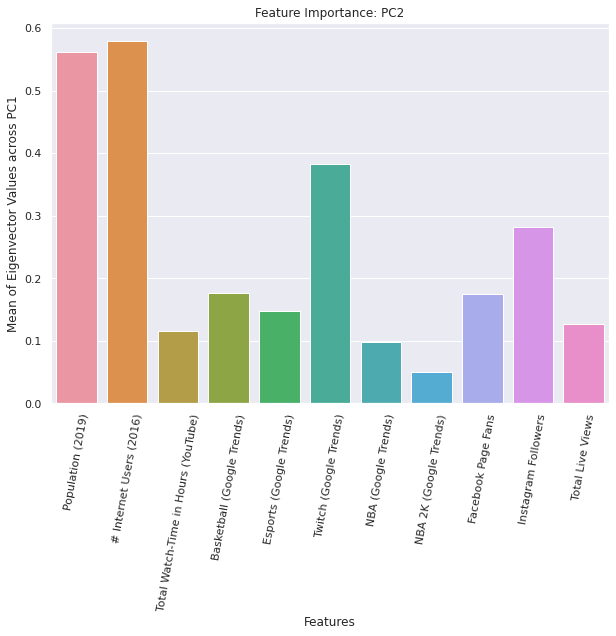

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x = feat_imp.columns, y = abs(feat_imp.iloc[1,:])).set_title('Feature Importance: PC2')
plt.ylabel('Mean of Eigenvector Values across PC1')
plt.xlabel('Features')
plt.xticks(rotation=80);

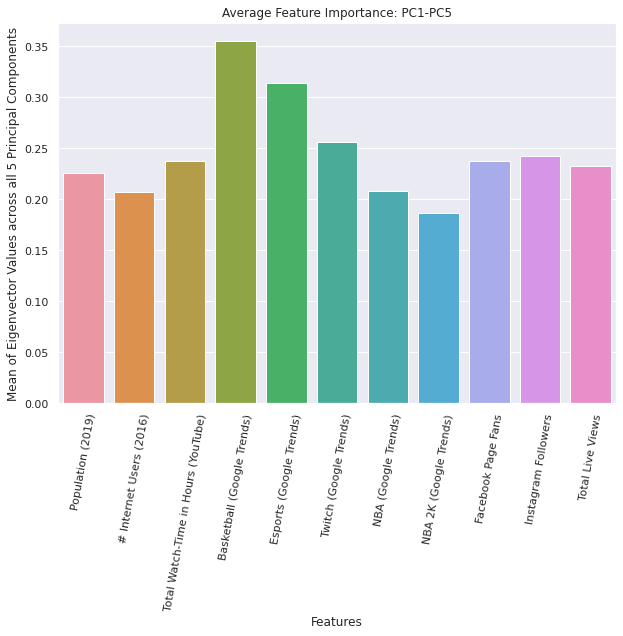

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x = feat_imp.columns, y = abs(feat_imp).mean(axis=0)).set_title('Average Feature Importance: PC1-PC5')
plt.ylabel('Mean of Eigenvector Values across all 5 Principal Components')
plt.xlabel('Features')
plt.xticks(rotation=80);

##K-Means Clustering

Deciding the number of clusters through the elbow method:

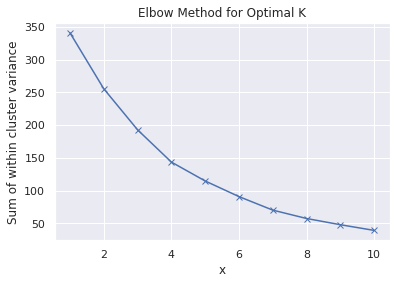

In [ ]:
lst = []
for n in np.arange(1,11):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train)
    score = kmeans.inertia_
    lst.append(score)

plt.plot(np.arange(1,11), lst, 'bx-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('x')
plt.ylabel('Sum of within cluster variance');

**Decided on k=4. These are the cluster labels.**

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train)
X['Cluster']=kmeans.labels_

In [ ]:
X[['Cluster']]

,Cluster
Country,
Argentina,1
Australia,0
Belgium,1
Brazil,0
Canada,0
Chile,1
Colombia,1
France,1
Germany,1


**Looking at the clusters through PCA.**

PCA with 2 components:

In [ ]:
pca = PCA(n_components=2)
prin = pca.fit_transform(X_train)

In [ ]:
d = {'x': prin[:,0], 'y': prin[:,1], 'country': list(X.index), 'cluster': kmeans.labels_}
df = pd.DataFrame(data=d)
df.to_csv('pca.tsv', sep='\t', index=False)

In [ ]:
from google.colab.output import eval_js
from IPython.display import Javascript

!git clone https://github.com/CAHLR/d3-scatterplot.git

Cloning into 'd3-scatterplot'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1022 (delta 9), reused 1 (delta 0), pack-reused 1003
Receiving objects: 100% (1022/1022), 1.94 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (590/590), done.


In [ ]:
def show_port(port, data_file, width=600, height=800):
    display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%d) + '/index.html?dataset=%s'
    fm.width = '90%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, data_file, height)))

port = 8000
data_file = 'pca.tsv'
height = 1600

get_ipython().system_raw('cd d3-scatterplot && python3 -m http.server %d &' % port) 
show_port(port, data_file, height)

<IPython.core.display.Javascript object>

## Isolation Forest

In [ ]:
isolation = pd.DataFrame(IsolationForest().fit_predict(X_train))
isolation = isolation.set_index(X.index)
isolation[isolation[0]==-1]

,0
Country,
Australia,-1
Brazil,-1
Canada,-1
India,-1
Indonesia,-1
Philippines,-1


## Recommendations

**Countries: UK, Philippines, Spain, Australia, and Brazil**

# All Countries


In [ ]:
new_data = pd.read_csv("More.csv").set_index('Country')

In [ ]:
new_data.head()

,Population (2019),# Internet Users (2016),Number of Smartphone users in 2020 (in millions),Number of Smartphone users in 2020,Final Consumption Expenditure (US$),GDP US$ (2019)
Country,,,,,,
Algeria,43053054,17438483.0,23.41,23410000,103573260328,169988236398
Argentina,44938712,31118074.0,32.37,32370000,421998288518,449663446954
Australia,25364307,21288325.0,20.30,20300000,1076747538950,1392680589329
Austria,8877067,7346364.0,7.34,7340000,323796670169,446314739528
Bahrain,1641172,1396667.0,1.46,1460000,21052526596,38574069149


In [ ]:
X_all = new_data.dropna()
X_all_train = preprocessing.scale(X_all)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


## K-Means

In [ ]:
lst = []
for n in np.arange(2,12):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_all_train)
    ss = silhouette_score(X_all_train, kmeans.labels_)
    lst.append(ss)
cluster = lst.index(max(lst))+2
cluster

2

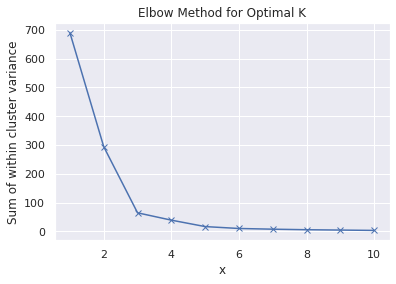

In [ ]:
lst = []
for n in np.arange(1,11):
  kmeans = KMeans(n_clusters=n)
  kmeans.fit(X_all_train)
  score = kmeans.inertia_
  lst.append(score)

plt.plot(np.arange(1,11), lst, 'bx-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('x')
plt.ylabel('Sum of within cluster variance');

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_all_train)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0], dtype=int32)

In [ ]:
clusters = pd.DataFrame(kmeans.labels_).set_index(X_all.index)
clusters[clusters[0]!=0]

,0
Country,
China,2
India,2
United States,1


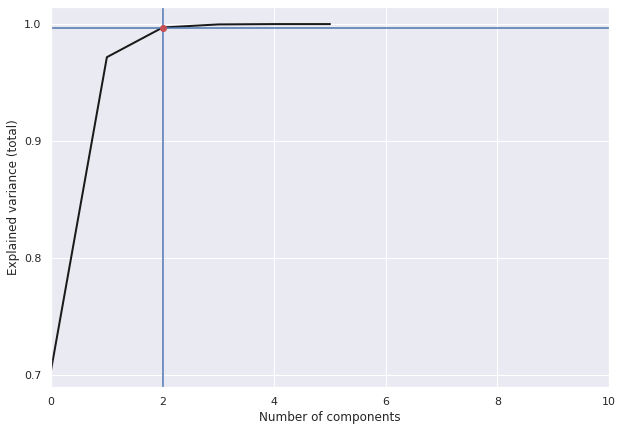

In [ ]:
decomp = PCA().fit(X_all_train)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(decomp.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Explained variance (total)')
plt.xlim(0, 10)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(2, c='b')
plt.axhline(0.997, c='b')
plt.plot(2, 0.997, 'ro')
plt.show();

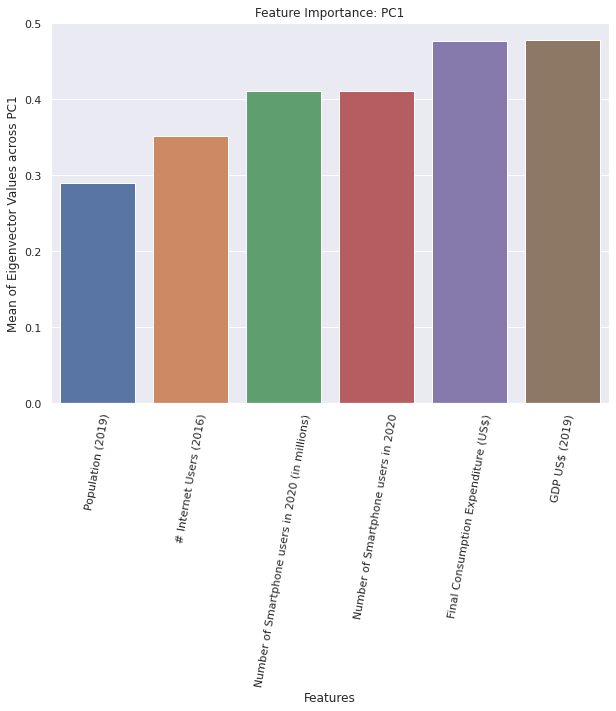

In [ ]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_all_train) 
feat_imp = pd.DataFrame(pca.components_)
feat_imp.columns = X_all.columns
plt.figure(figsize=(10,7))
sns.barplot(x = feat_imp.columns, y = abs(feat_imp.iloc[0,:])).set_title('Feature Importance: PC1')
plt.ylabel('Mean of Eigenvector Values across PC1')
plt.xlabel('Features')
plt.xticks(rotation=80);

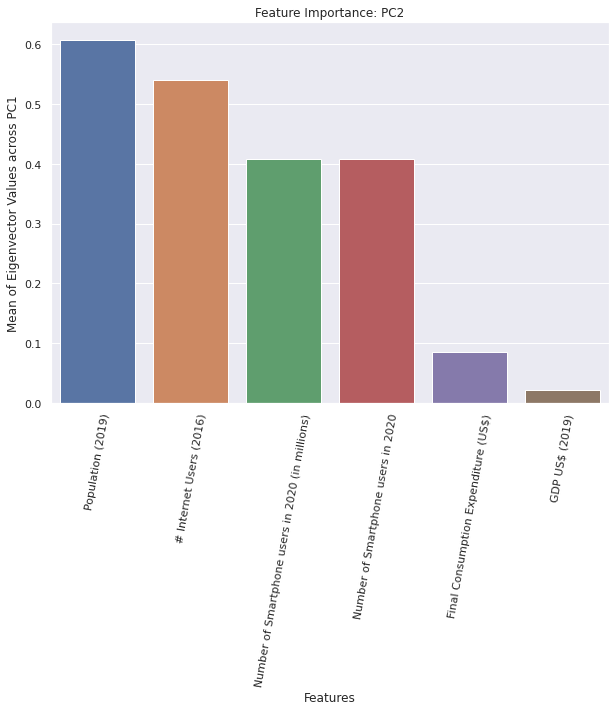

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x = feat_imp.columns, y = abs(feat_imp.iloc[1,:])).set_title('Feature Importance: PC2')
plt.ylabel('Mean of Eigenvector Values across PC1')
plt.xlabel('Features')
plt.xticks(rotation=80);

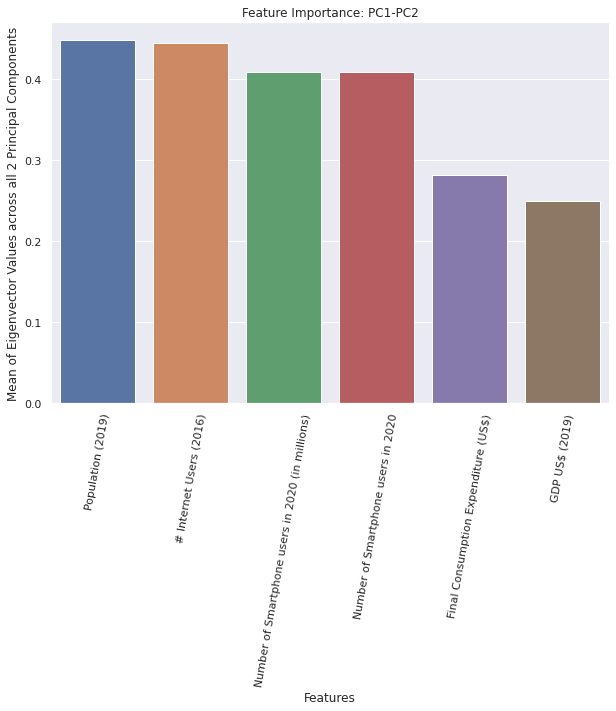

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x = feat_imp.columns, y = abs(feat_imp).mean(axis=0)).set_title('Feature Importance: PC1-PC2')
plt.ylabel('Mean of Eigenvector Values across all 2 Principal Components')
plt.xlabel('Features')
plt.xticks(rotation=80);

## Isolation Forest

In [ ]:
isolation = pd.DataFrame(IsolationForest().fit_predict(X_all_train))
isolation = isolation.set_index(X_all.index)
isolation[isolation[0]!=1]

,0
Country,
Brazil,-1
China,-1
France,-1
Germany,-1
India,-1
Indonesia,-1
Japan,-1
Mexico,-1
Nigeria,-1
